In [ ]:
!pip install -qq transformers
# Hello 

     |████████████████████████████████| 2.8 MB 5.3 MB/s 
     |████████████████████████████████| 52 kB 1.4 MB/s 
     |████████████████████████████████| 3.3 MB 32.6 MB/s 
     |████████████████████████████████| 636 kB 45.8 MB/s 
     |████████████████████████████████| 895 kB 45.7 MB/s 


In [ ]:
import transformers
from transformers import BertForSequenceClassification, BertTokenizer, AdamW, get_linear_schedule_with_warmup
# Try BertForSequenceClassification
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader


%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
reviews_df = pd.read_csv("reviews_preprocessed.csv")
reviews_df.head()

,content,score,thumbsUpCount,appId,review_len,word_count,polarity
0,user interface horrible way task show difficul...,0,145,com.anydo,242,40,0.031481
1,keep lose event save enter recur event might s...,0,2,com.anydo,128,22,0.000000
2,adhd want try app help remember chore around h...,0,0,com.anydo,139,22,0.500000
3,point pay premium colour tag dont even show ca...,0,3,com.anydo,123,21,0.000000
4,installed look around instal clunky feel intui...,0,1,com.anydo,136,20,0.100000


In [ ]:
reviews_df.shape

(11879, 7)

In [ ]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11879 entries, 0 to 11878
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   content        11879 non-null  object 
 1   score          11879 non-null  int64  
 2   thumbsUpCount  11879 non-null  int64  
 3   appId          11879 non-null  object 
 4   review_len     11879 non-null  int64  
 5   word_count     11879 non-null  int64  
 6   polarity       11879 non-null  float64
dtypes: float64(1), int64(4), object(2)
memory usage: 649.8+ KB


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


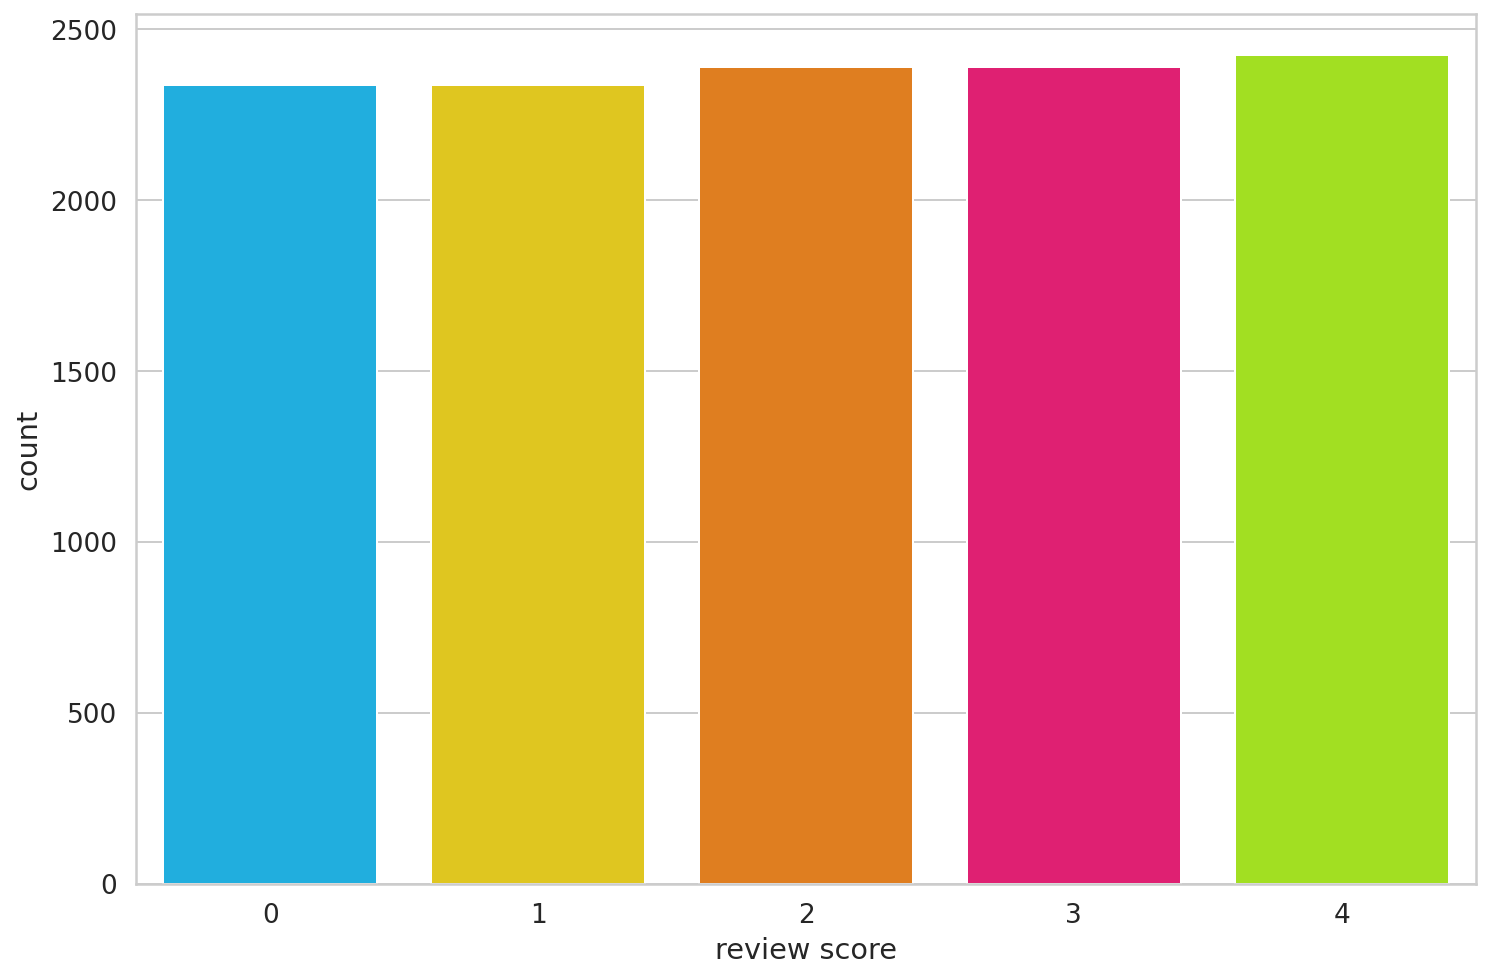

In [ ]:
sns.countplot(reviews_df.score)
plt.xlabel('review score');

In [ ]:
class_names = ['strongly_neg','neg','neutral','pos','strongly_pos']

## Data Preprocessing

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'

In [ ]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: When was I last outside? I am stuck at home for 2 weeks.
   Tokens: ['when', 'was', 'i', 'last', 'outside', '?', 'i', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
Token IDs: [2043, 2001, 1045, 2197, 2648, 1029, 1045, 2572, 5881, 2012, 2188, 2005, 1016, 3134, 1012]


In [ ]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

In [ ]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

In [ ]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [ ]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

In [ ]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  truncation=True,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [ ]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([ 101, 2043, 2001, 1045, 2197, 2648, 1029, 1045, 2572, 5881, 2012, 2188,
        2005, 1016, 3134, 1012,  102,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

In [ ]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'when',
 'was',
 'i',
 'last',
 'outside',
 '?',
 'i',
 'am',
 'stuck',
 'at',
 'home',
 'for',
 '2',
 'weeks',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [ ]:
# we are required to have sentences of equal length => padding
# attension mask => padding items in sequences took 0 else 1
# in tokenizer we have => tokenize , convert_tokens_to_ids

In [ ]:
# Choosing Sequence Length
# Choose the thresthreshold length for padding
reviews_lens = []
for txt in reviews_df.content:
  tokens = tokenizer.encode(txt, max_length=512,truncation=True)
  reviews_lens.append(len(tokens))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


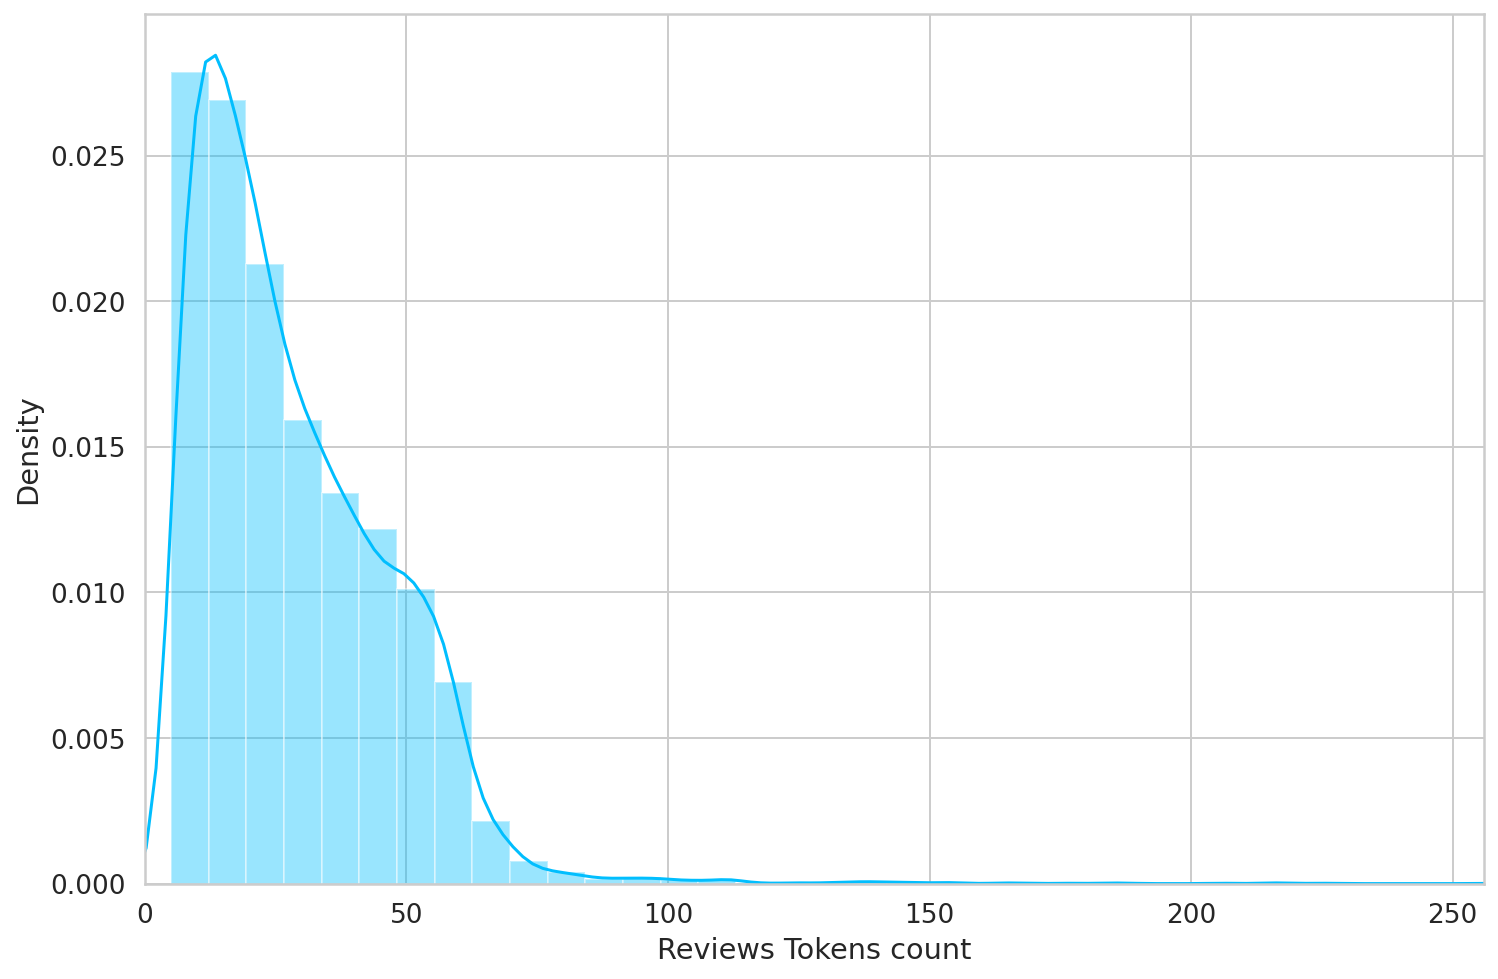

In [ ]:
sns.distplot(reviews_lens)
plt.xlim([0, 256]);
plt.xlabel('Reviews Tokens count');
# So based on the plot below we will choose 128

In [ ]:
MAX_LEN = 100

In [ ]:
class GPReviewDataset(Dataset):
  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  def __len__(self):
    return len(self.reviews)
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      truncation=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
    )
    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
# Split into training and testing data
x = reviews_df['content']
y = reviews_df['score']
x, x_test, y, y_test = train_test_split(x,y, stratify=y, test_size=0.16, random_state=42)

In [ ]:
train_dataset = pd.DataFrame({"content": x, "score":y})

In [ ]:
train_dataset.head()

,content,score
9129,move slow small see,1
3459,app awesome encouraging habit since satisfy pr...,4
2573,ok change 4 5 star new design app pa update ap...,4
166,basic feature like recur task behind pay wall ...,0
675,great app need voiceover would bravo,3


In [ ]:
train_dataset, val_dataset = train_test_split(
  train_dataset,
  test_size=0.15,
  random_state=RANDOM_SEED
)
train_dataset.shape, val_dataset.shape

((8481, 2), (1497, 2))

In [ ]:
test_dataset = pd.DataFrame({"content": x_test, "score":y_test})
test_dataset.head()

,content,score
2561,one best list apps ive use ive used lot best t...,4
5728,pretty decent ignores default repeat value hon...,3
1440,im look schedule call type call click call but...,2
9469,find app really hard use log every 2 sec use,0
4215,app awesome help focus even well improve great...,3


In [ ]:
#train_dataset, test_dataset = train_test_split(
#  reviews,
#  test_size=0.2,
#  random_state=RANDOM_SEED
#)
#val_dataset, test_dataset = train_test_split(
#  test_dataset,
#  test_size=0.5,
#  random_state=RANDOM_SEED
#)

In [ ]:
#x.shape, y.shape, x_test.shape, y_test.shape

In [ ]:
train_dataset.shape, val_dataset.shape, test_dataset.shape

((8481, 2), (1497, 2), (1901, 2))

In [ ]:
train_dataset = train_dataset.sample(frac=1).reset_index(drop=True)

In [ ]:
test_dataset = test_dataset.sample(frac=1).reset_index(drop=True)

In [ ]:
val_dataset = val_dataset.sample(frac=1).reset_index(drop=True)

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.content.to_numpy(),
    targets=df.score.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2
  )

In [ ]:
BATCH_SIZE = 16
train_data_loader = create_data_loader(train_dataset, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(val_dataset, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(test_dataset, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 100])
torch.Size([16, 100])
torch.Size([16])


In [ ]:
bert_model = BertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False, num_labels=5)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
bert_model.config.return_dict

False

In [ ]:
bert_model.config.num_labels

5

In [ ]:
bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask']
)[0]


tensor([[ 0.2276,  0.5143, -0.9989, -0.0562, -0.6570]],
       grad_fn=<AddmmBackward>)

In [ ]:
bert_model.config.hidden_size

768

In [ ]:
class SentimentClassifier(nn.Module):
# def __init__(self, n_classes):
  def __init__(self , n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False, num_labels= n_classes)
#   self.drop = nn.Dropout(p=0.3)
#   self.out = nn.Linear(self.xlnet.config.hidden_size, n_classes)
  def forward(self, input_ids, attention_mask):
    
    output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
#    print(output[0])
#   output = self.drop(pooled_output)
#   return self.out(output)
    return output[0]

In [ ]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 100])
torch.Size([16, 100])


In [ ]:
nn.functional.softmax(model(input_ids, attention_mask),dim=1)

tensor([[0.2818, 0.1275, 0.2567, 0.1166, 0.2174],
        [0.2586, 0.1271, 0.2641, 0.1361, 0.2140],
        [0.2571, 0.1314, 0.2683, 0.1389, 0.2042],
        [0.2431, 0.1238, 0.2789, 0.1430, 0.2112],
        [0.2774, 0.1224, 0.2664, 0.1260, 0.2079],
        [0.2760, 0.1281, 0.2715, 0.1224, 0.2021],
        [0.2498, 0.1230, 0.2828, 0.1463, 0.1981],
        [0.2487, 0.1212, 0.2770, 0.1535, 0.1997],
        [0.2532, 0.1285, 0.2735, 0.1431, 0.2018],
        [0.2769, 0.1373, 0.2669, 0.1367, 0.1822],
        [0.2672, 0.1229, 0.2674, 0.1403, 0.2022],
        [0.2618, 0.1198, 0.2753, 0.1401, 0.2030],
        [0.2491, 0.1268, 0.2773, 0.1359, 0.2109],
        [0.3083, 0.1284, 0.2548, 0.1254, 0.1831],
        [0.2900, 0.1297, 0.2555, 0.1205, 0.2043],
        [0.2328, 0.1308, 0.2748, 0.1366, 0.2249]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)

In [ ]:
EPOCHS = 10
optimizer = AdamW(model.parameters(), lr=7e-6, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 30)
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(train_dataset)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')  

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(val_dataset)
  )
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

    
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_stateb.bin')
    best_accuracy = val_acc

Epoch 1/10
------------------------------
Train loss 1.319244497464426 accuracy 0.41209762999646266
Val   loss 1.1886012078599726 accuracy 0.49098196392785576

Epoch 2/10
------------------------------
Train loss 1.0881480983197127 accuracy 0.5301261643674094
Val   loss 1.1892806640330782 accuracy 0.4876419505678023

Epoch 3/10
------------------------------
Train loss 0.9645559707491635 accuracy 0.5959202924183469
Val   loss 1.2260528917008258 accuracy 0.49231796927187715

Epoch 4/10
------------------------------
Train loss 0.8677317015756546 accuracy 0.6506308218370475
Val   loss 1.2820282889173387 accuracy 0.4869739478957916

Epoch 5/10
------------------------------
Train loss 0.7882080743766325 accuracy 0.6870652045749321
Val   loss 1.3493460144134277 accuracy 0.4929859719438878

Epoch 6/10
------------------------------
Train loss 0.719241759001423 accuracy 0.7273906378964744
Val   loss 1.411412388086319 accuracy 0.48630594522378096

Epoch 7/10
------------------------------
Tra

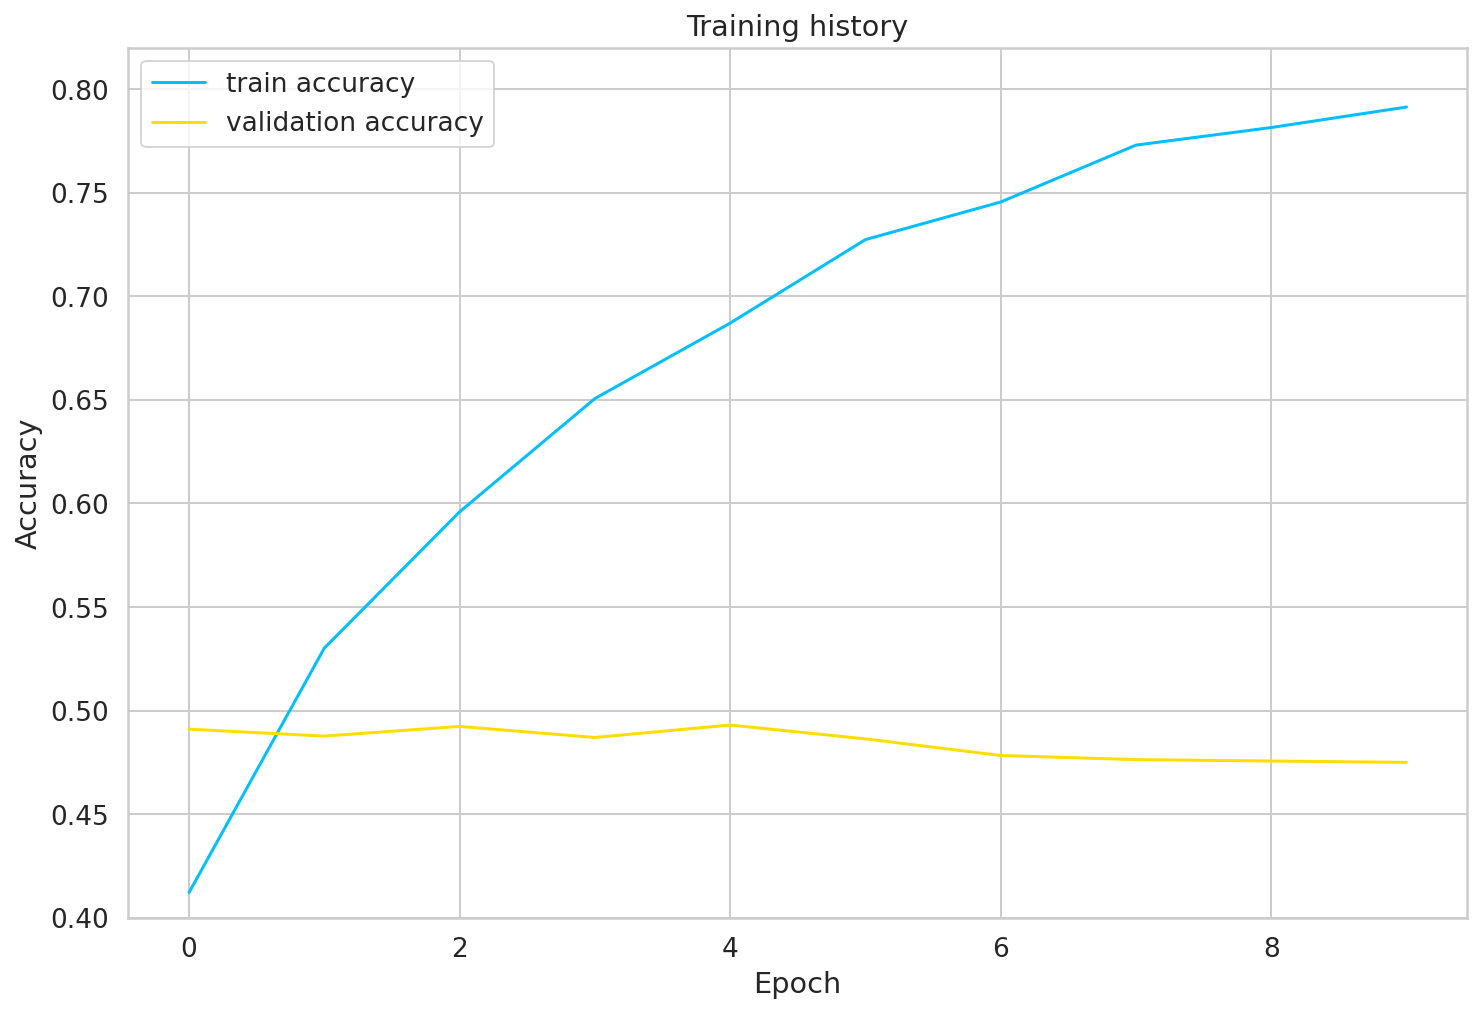

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.4, 0.82]);
# Explain why you run only 7 epochs and stop the running

In [ ]:
model = SentimentClassifier(len(class_names))
model.load_state_dict(torch.load('best_model_stateb.bin'))
model = model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
test_acc, test_loss = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(test_dataset)
)

In [ ]:
test_acc.item()

0.4792214623882167

In [ ]:
test_loss

1.3733986180369593

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()

  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  enter = True
  with torch.no_grad():
    for d in data_loader:
      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      if(enter):
        print(outputs)
        enter = False


      _, preds = torch.max(outputs, dim=1)
      review_texts.extend(texts)
      predictions.extend(preds)
      softmax_outputs = nn.functional.softmax(outputs, dim=1)
      prediction_probs.extend(softmax_outputs)
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_test_old = y_test

In [ ]:
y_review_texts, y_pred, y_pred_proba, y_test = get_predictions(
  model,
  test_data_loader
)

tensor([[-1.8927e+00, -2.1471e+00, -1.3347e+00,  1.6619e+00,  3.7896e+00],
        [-1.9364e+00, -2.3269e+00, -1.3796e+00,  1.7851e+00,  4.0061e+00],
        [-1.7580e+00,  2.8216e-03,  2.1288e+00,  1.9746e+00, -1.8326e+00],
        [ 3.6666e+00,  7.2644e-01, -1.1255e+00, -1.8177e+00, -1.0730e+00],
        [-8.4186e-01, -2.0017e+00, -1.8884e+00,  3.3998e-01,  4.2791e+00],
        [-2.1711e+00, -2.3621e+00, -8.6501e-01,  2.5979e+00,  3.1451e+00],
        [-2.1706e+00, -2.5064e+00, -1.0871e+00,  2.3961e+00,  3.4541e+00],
        [ 3.4216e+00,  1.2297e+00, -8.9864e-01, -1.7508e+00, -1.7449e+00],
        [-2.0231e+00,  4.1940e-02,  2.1674e+00,  1.5147e+00, -1.8730e+00],
        [ 8.2646e-01,  2.5246e+00,  1.2222e+00, -1.5939e+00, -3.1541e+00],
        [-2.0784e+00, -6.3195e-01,  1.2846e+00,  2.1681e+00, -4.0579e-01],
        [-8.6670e-01, -2.1240e+00, -1.9316e+00,  2.1933e-01,  4.5126e+00],
        [-1.1996e+00, -2.2362e+00, -1.8763e+00,  6.6605e-01,  4.4532e+00],
        [-1.7047e+00, -2.

In [ ]:
y_pred

tensor([4, 4, 2,  ..., 0, 2, 1])

In [ ]:
y_pred_proba

tensor([[0.0030, 0.0023, 0.0053, 0.1053, 0.8841],
        [0.0023, 0.0016, 0.0041, 0.0971, 0.8949],
        [0.0102, 0.0592, 0.4960, 0.4252, 0.0094],
        ...,
        [0.6816, 0.2637, 0.0321, 0.0074, 0.0152],
        [0.0133, 0.0551, 0.7323, 0.1906, 0.0087],
        [0.1515, 0.6560, 0.1787, 0.0110, 0.0028]])

In [ ]:
y_test

tensor([3, 4, 2,  ..., 1, 1, 2])

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

strongly_neg       0.55      0.61      0.58       374
         neg       0.37      0.34      0.35       374
     neutral       0.34      0.33      0.34       383
         pos       0.45      0.46      0.46       382
strongly_pos       0.67      0.65      0.66       388

    accuracy                           0.48      1901
   macro avg       0.48      0.48      0.48      1901
weighted avg       0.48      0.48      0.48      1901



In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="f", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');


In [ ]:
conf_mx = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(conf_mx, index=class_names, columns=class_names)
print(conf_mx)

[[229  84  41  13   7]
 [126 126  86  28   8]
 [ 46 105 127  84  21]
 [  9  18  88 176  91]
 [  8   9  30  88 253]]


In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
print(row_sums)
norm_conf_mx = conf_mx / row_sums

[[374]
 [374]
 [383]
 [382]
 [388]]


In [ ]:
print(norm_conf_mx)

[[0.61229947 0.22459893 0.10962567 0.03475936 0.01871658]
 [0.3368984  0.3368984  0.22994652 0.07486631 0.02139037]
 [0.12010444 0.27415144 0.33159269 0.21932115 0.05483029]
 [0.02356021 0.04712042 0.23036649 0.46073298 0.2382199 ]
 [0.02061856 0.02319588 0.07731959 0.22680412 0.65206186]]


In [ ]:
df_norm_cm = pd.DataFrame(norm_conf_mx, index=class_names, columns=class_names)

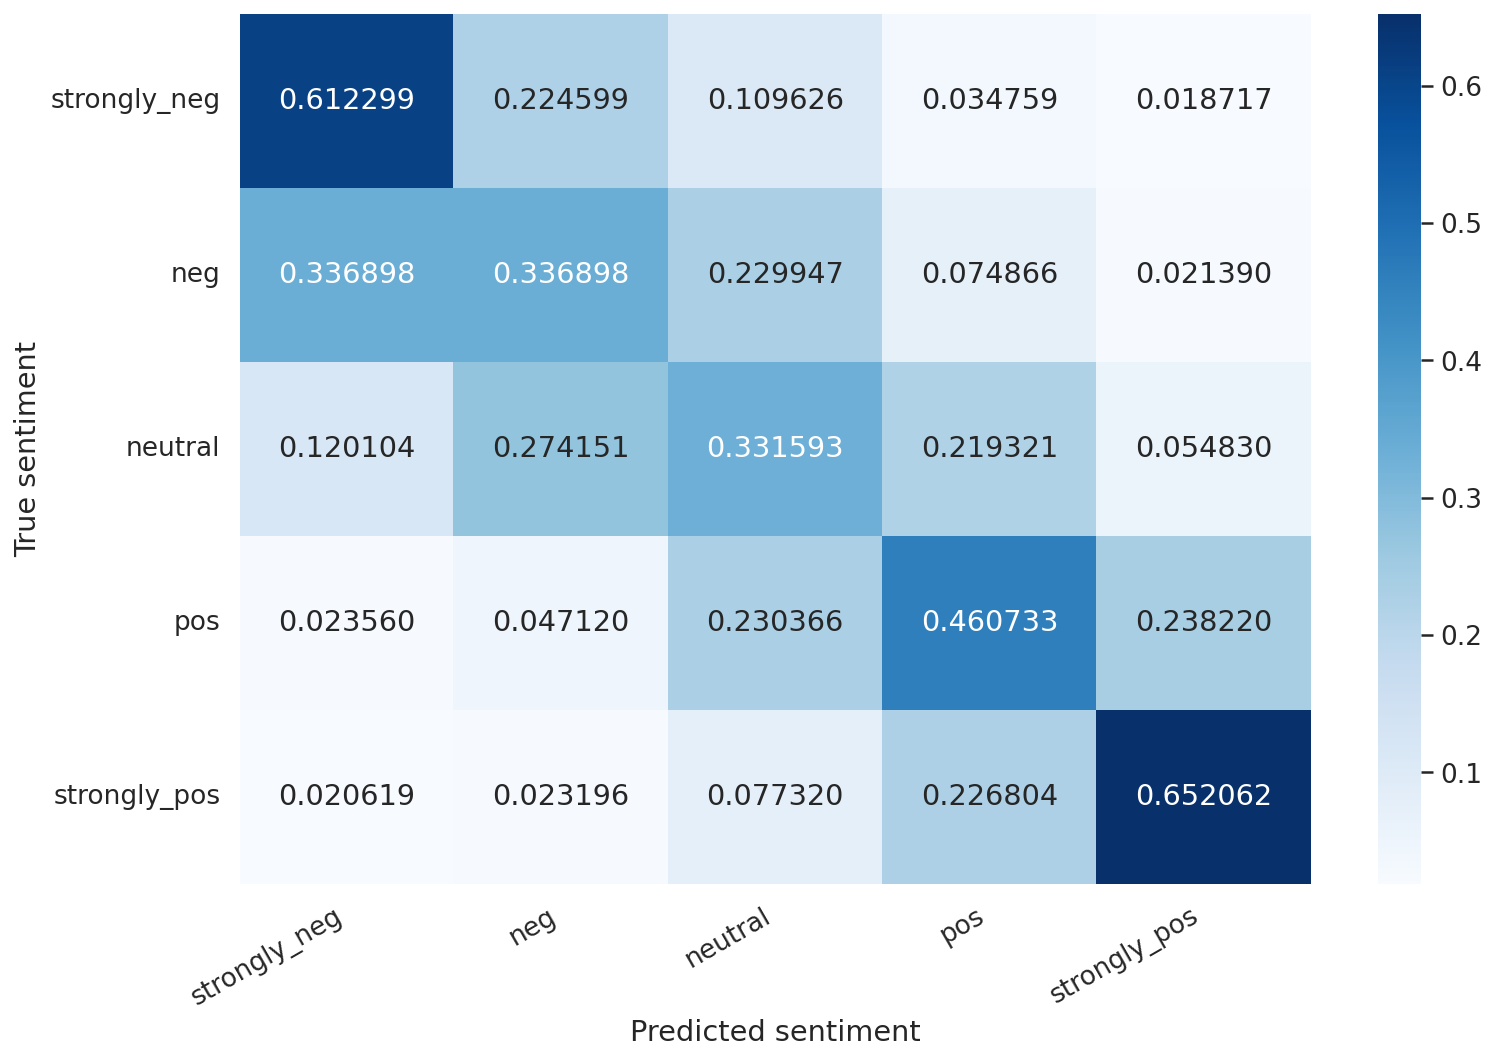

In [ ]:
show_confusion_matrix(df_norm_cm)

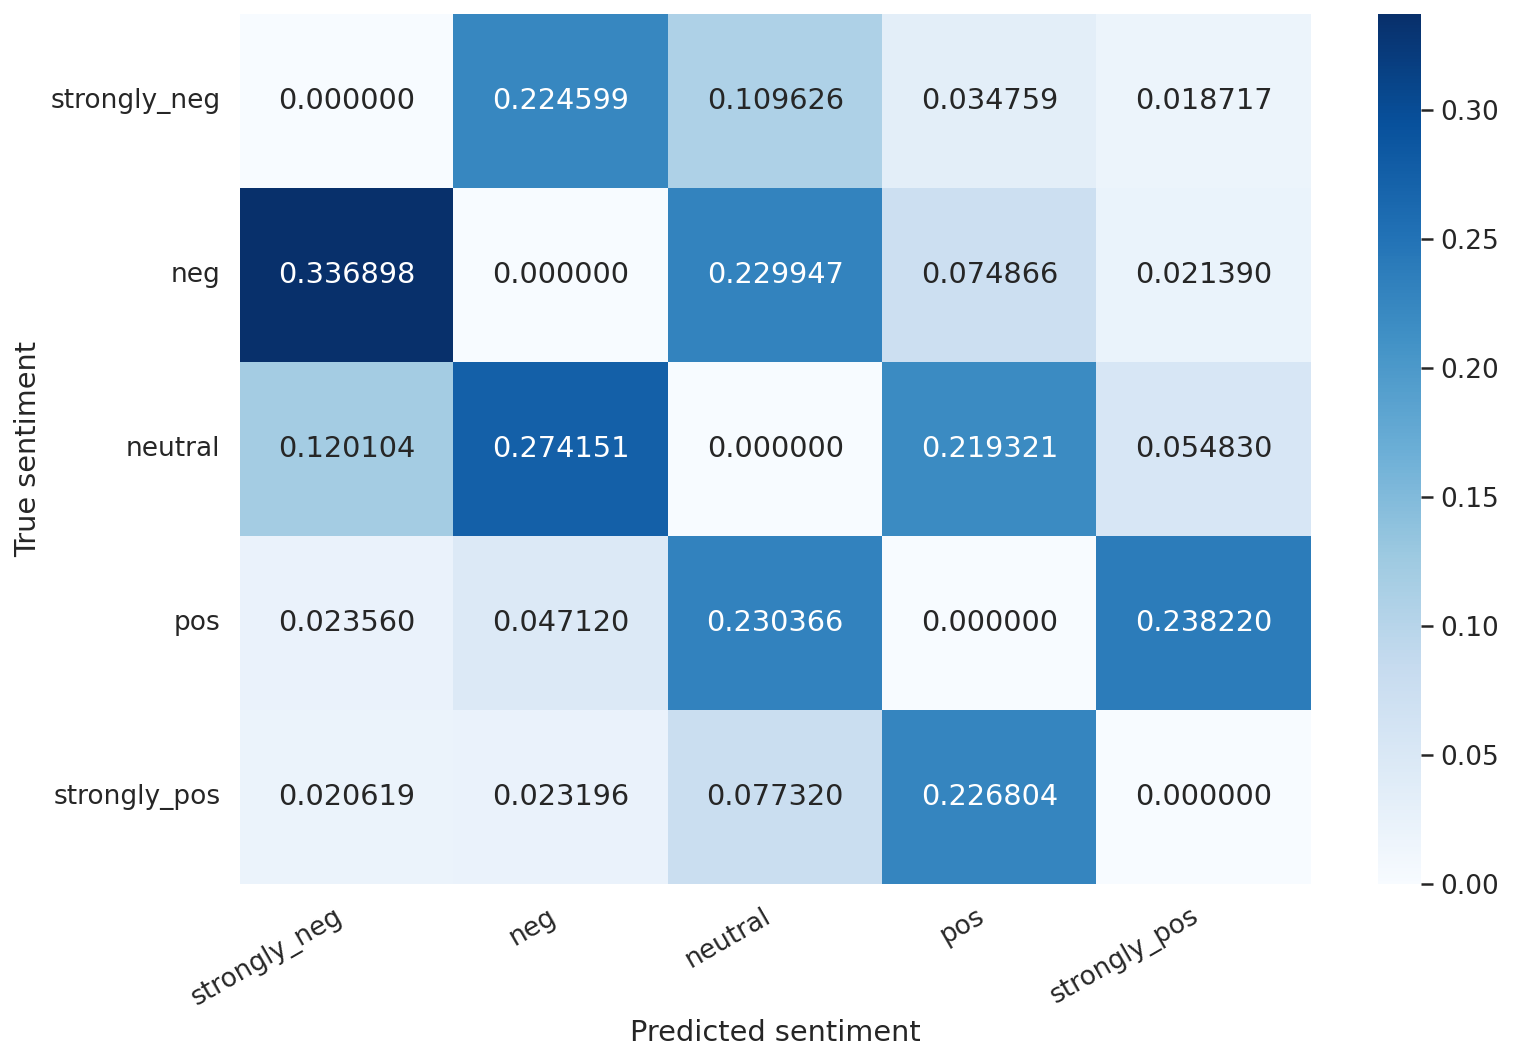

In [ ]:
np.fill_diagonal(norm_conf_mx, 0)
df_norm_cm = pd.DataFrame(norm_conf_mx, index=class_names, columns=class_names)
show_confusion_matrix(df_norm_cm)

In [ ]:
print(norm_conf_mx)

[[0.         0.22459893 0.10962567 0.03475936 0.01871658]
 [0.3368984  0.         0.22994652 0.07486631 0.02139037]
 [0.12010444 0.27415144 0.         0.21932115 0.05483029]
 [0.02356021 0.04712042 0.23036649 0.         0.2382199 ]
 [0.02061856 0.02319588 0.07731959 0.22680412 0.        ]]


Precison / Recall

In [ ]:
from sklearn.preprocessing import label_binarize

In [ ]:
# Use label_binarize to be multi-label like settings
y_test_mult = label_binarize(y_test, classes=[0, 1, 2, 3, 4])
print(y_test_mult)
print(y_pred_proba)

n_classes = y_test_mult.shape[1]
n_classes

[[0 0 0 1 0]
 [0 0 0 0 1]
 [0 0 1 0 0]
 ...
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 0 1 0 0]]
tensor([[0.0030, 0.0023, 0.0053, 0.1053, 0.8841],
        [0.0023, 0.0016, 0.0041, 0.0971, 0.8949],
        [0.0102, 0.0592, 0.4960, 0.4252, 0.0094],
        ...,
        [0.6816, 0.2637, 0.0321, 0.0074, 0.0152],
        [0.0133, 0.0551, 0.7323, 0.1906, 0.0087],
        [0.1515, 0.6560, 0.1787, 0.0110, 0.0028]])


5

In [ ]:
print(len(y_test_mult))
print(len(y_pred_proba))

1901
1901


In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

In [ ]:
# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_mult[:, i],
                                                        y_pred_proba[:, i])
    
    curr_precision = precision[i]
    curr_recall = recall[i]

    precision[i] = precision[i][curr_precision+curr_recall > 0.0]
    recall[i] = recall[i][curr_precision+curr_recall > 0.0]

    average_precision[i] = average_precision_score(y_test_mult[:, i], y_pred_proba[:, i])

In [ ]:
# A "macro-average": Averaging over classes
# ====> Cannot do macro-average by the below approach because:
# len(precision[i]) depend on i (the unique probas in column i)
# the thresholds that based on it the precision & recall are calculated is not the same at the corresponding indices
#precision_sum = precision[0] + precision[1] + precision[2] + precision[3] + precision[4]
#precision["macro"] = precision_sum / 5
#recall_sum = recall[0] + recall[1] + recall[2] + recall[3] + recall[4]
#recall["macro"] = recall_sum / 5

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test_mult.ravel(),
    y_pred_proba.ravel())


# compute F1 score
f1_score = dict()
# for each class
for i in range(n_classes):
  f1_score[i] = 2*((precision[i]*recall[i])/(precision[i]+recall[i]))

f1_score["micro"] = 2*((precision["micro"]*recall["micro"])/(precision["micro"]+recall["micro"]))

In [ ]:
average_precision["micro"] = average_precision_score(y_test_mult, y_pred_proba,
                                                     average="micro")
average_precision["macro"] = average_precision_score(y_test_mult, y_pred_proba,
                                                     average="macro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))
print('Average precision score, macro-averaged over all classes: {0:0.2f}'
      .format(average_precision["macro"]))

Average precision score, micro-averaged over all classes: 0.52
Average precision score, macro-averaged over all classes: 0.49


Plot the micro-averaged Precision-Recall curve

Text(0.5, 1.0, 'Average precision score, micro-averaged over all classes: AP=0.52')

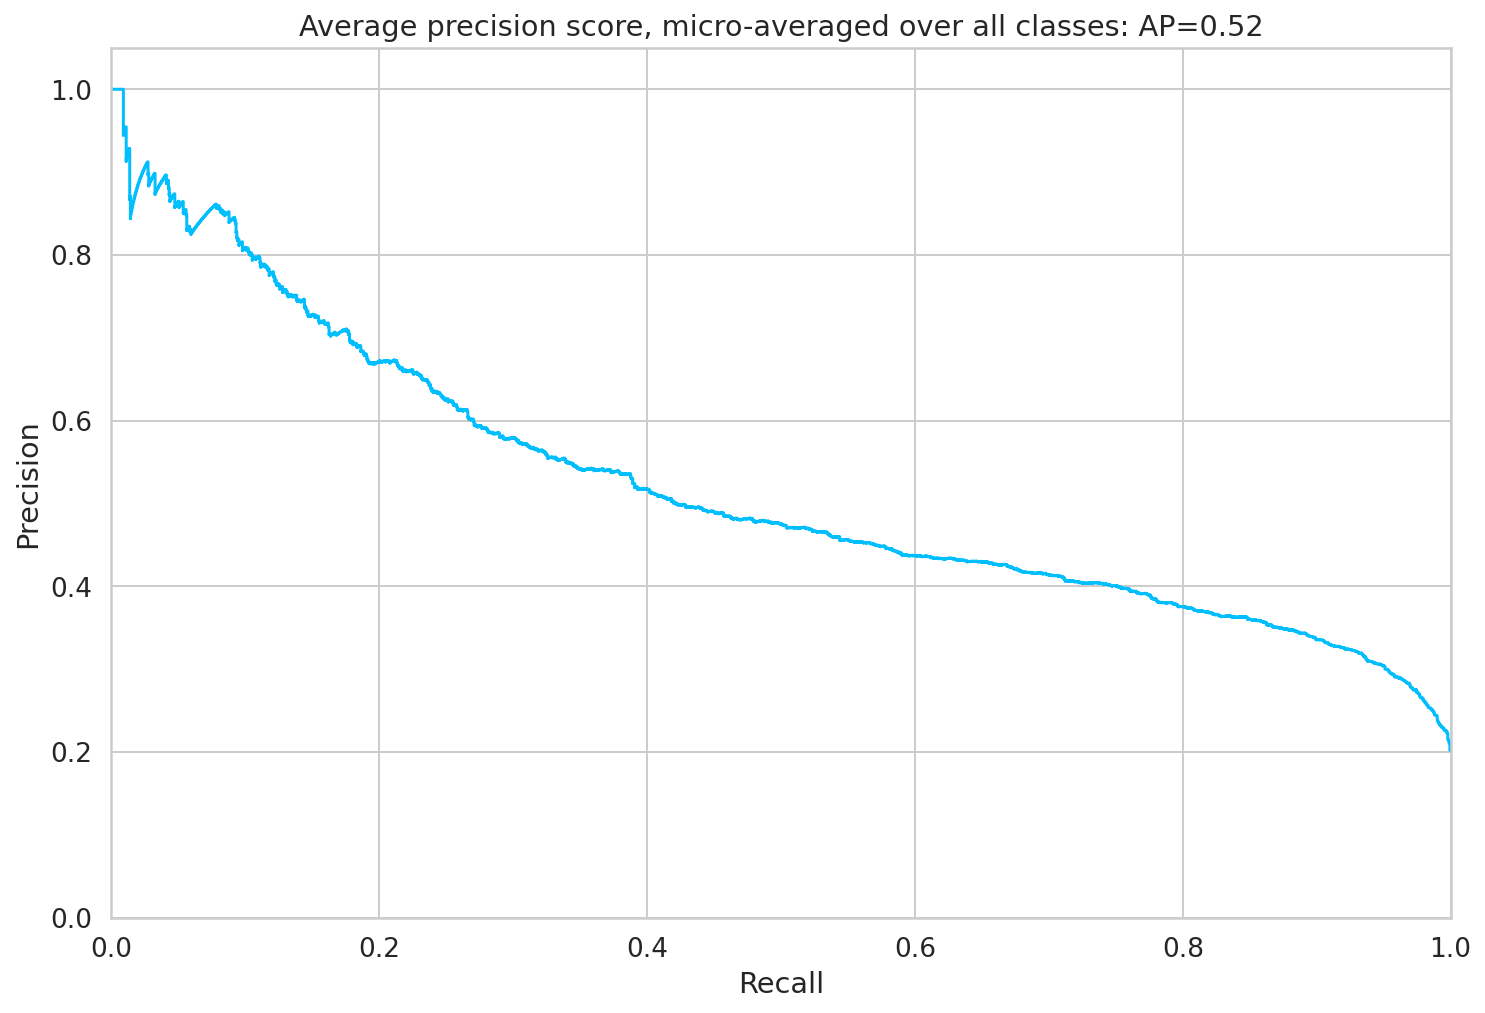

In [ ]:
plt.figure()
plt.step(recall['micro'], precision['micro'], where='post')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))

Plot Precision-Recall curve for each class and iso-f1 curves

In [ ]:
from itertools import cycle

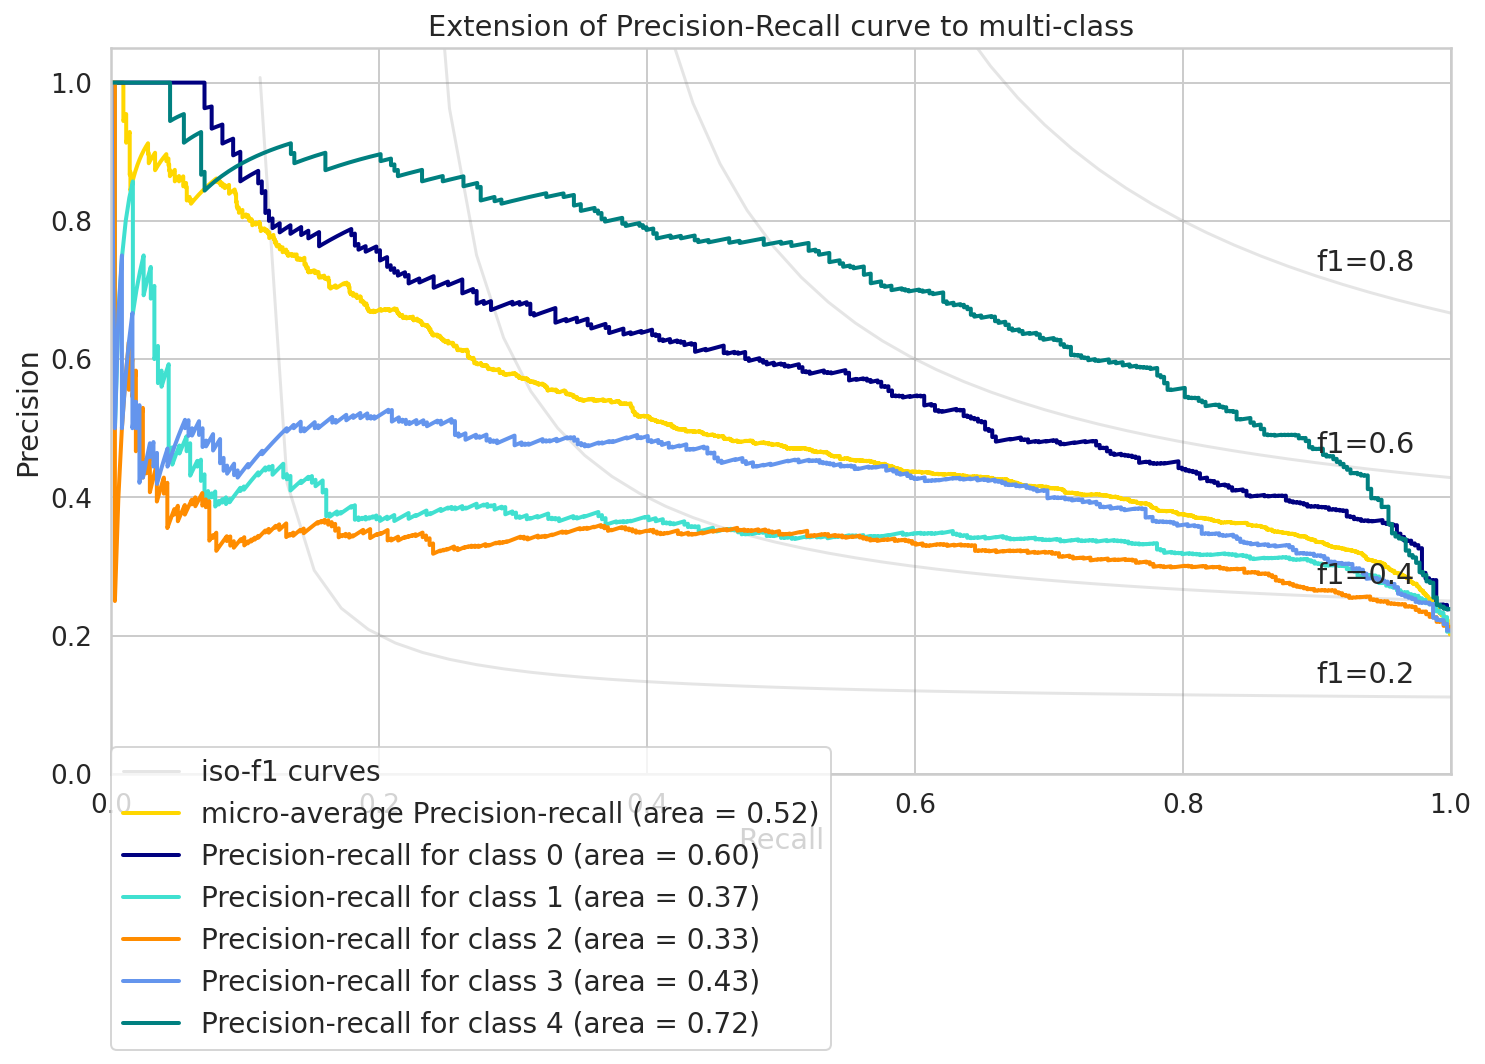

In [ ]:
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(12, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(n_classes), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                  ''.format(i, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(0, -.38), prop=dict(size=14))


plt.show()


In [ ]:
idx = 2

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_proba[idx]
})

print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

fun cool would 5 star know habitica die quickly litterally log
partyconfusion dead someone didnt log day also bos deal damage deal
damage deal healer heal 6 health 50 use 25 mana point teammate use
mana try keep alive check daily yesterday die dealt 11 bos deal 14
plus fix team agree fix

True sentiment: neutral


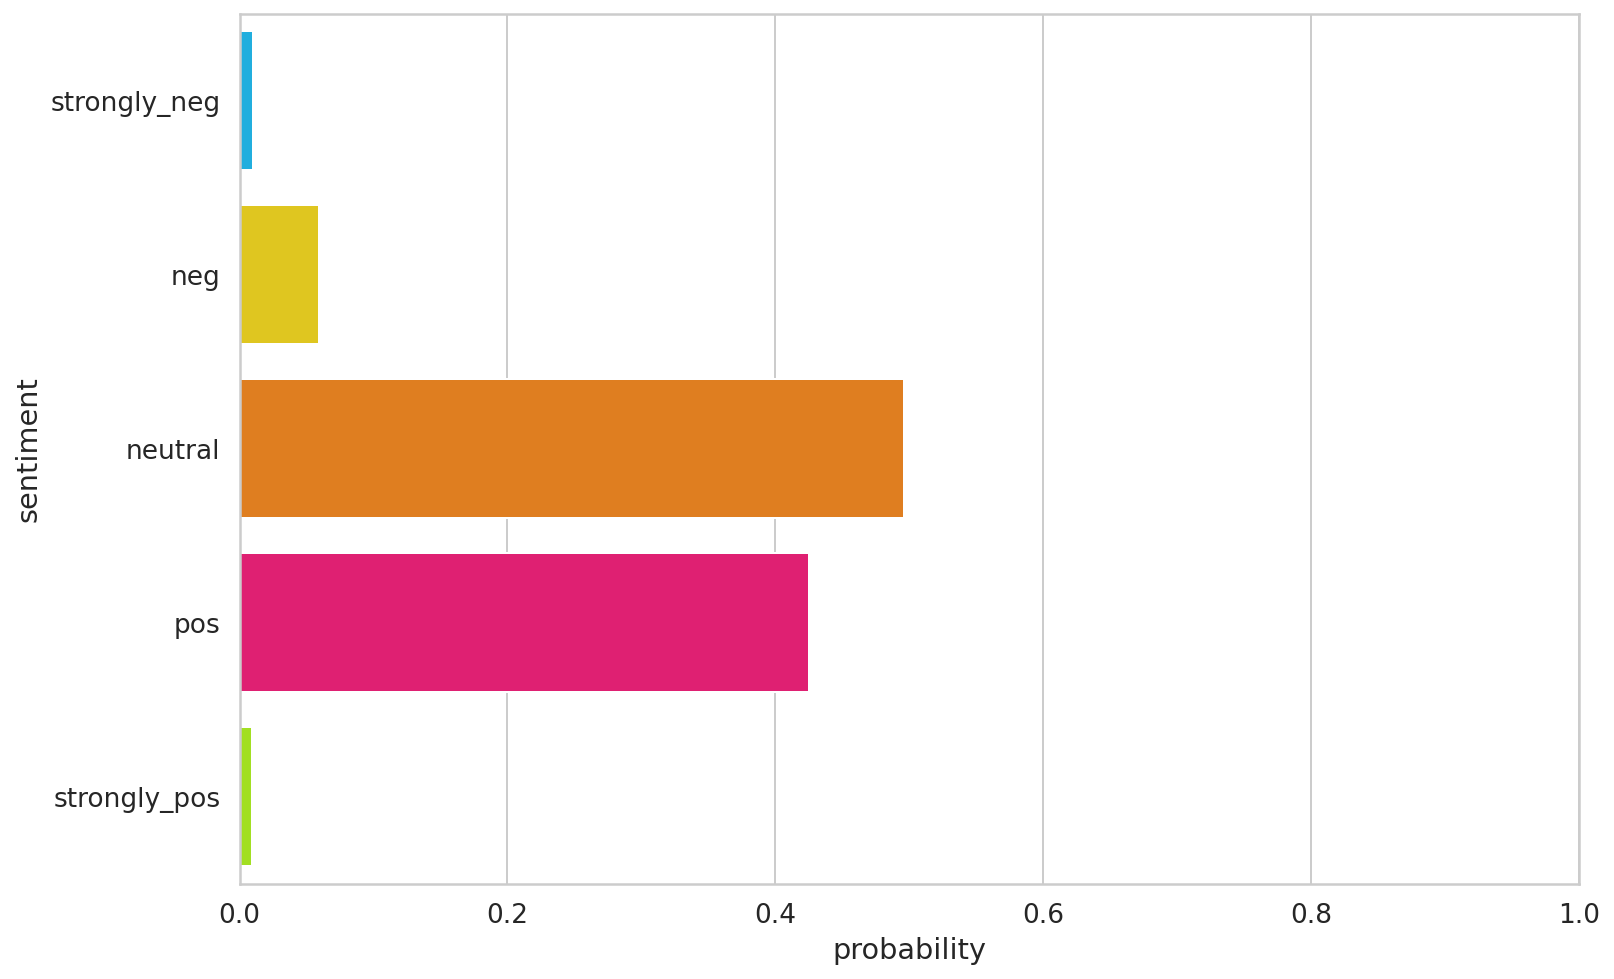

In [ ]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

In [ ]:
review_text = "I love completing my todos! Best app ever!!!"

In [ ]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2204: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')


Review text: I love completing my todos! Best app ever!!!
Sentiment  : strongly_pos
